In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


e:\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.cuda.is_available()

False

In [2]:
#parameters:

epochs=10
batch_size=64

input=3
layer=32
classes=4

train_images_path = 'SportBalls\Train'
test_images_path = 'SportBalls\Test'
labels_path='SportBalls\Train\labels.csv'

In [3]:

# Load labels without column names and specify them
column_names = ['img_name', 'label_ball_1', 'label_ball_2']
labels_df = pd.read_csv(labels_path, header=None, names=column_names)

# Debug: print the first few rows and columns of the DataFrame
print(labels_df.head())
print(labels_df.columns)

# Create binary labels for multi-label classification
def create_binary_labels(df):
    df['label_baseball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 0 or x['label_ball_2'] == 0 else 0, axis=1)
    df['label_basketball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 1 or x['label_ball_2'] == 1 else 0, axis=1)
    df['label_volleyball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 2 or x['label_ball_2'] == 2 else 0, axis=1)
    df['label_soccerball'] = df.apply(lambda x: 1 if x['label_ball_1'] == 3 or x['label_ball_2'] == 3 else 0, axis=1)
    return df

labels_df = create_binary_labels(labels_df)

# Custom Dataset class
class SportsBallsDataset(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_names = sorted(os.listdir(img_dir))
        if labels_df is not None:
            self.labels = labels_df[['label_baseball', 'label_basketball', 'label_volleyball', 'label_soccerball']].values

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels_df is not None:
            labels = self.labels[idx]
            return image, torch.tensor(labels, dtype=torch.float32)
        else:
            return image, self.img_names[idx]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets
train_dataset = SportsBallsDataset(img_dir=train_images_path, labels_df=labels_df, transform=transform)
test_dataset = SportsBallsDataset(img_dir=test_images_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


    img_name  label_ball_1  label_ball_2
0  img_00000             2             3
1  img_00001             2             2
2  img_00002             1             0
3  img_00003             0             0
4  img_00004             2             2
Index(['img_name', 'label_ball_1', 'label_ball_2'], dtype='object')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


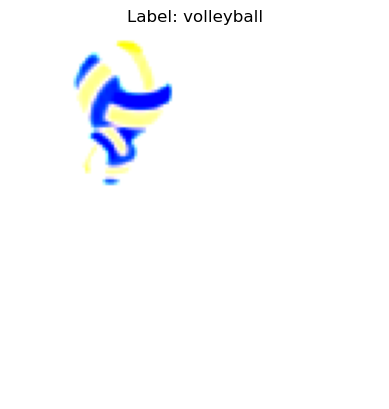

In [4]:

def display_random_image_with_label():
    idx = random.randint(0, len(train_dataset) - 1)
    image, labels = train_dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    label_names = ['baseball', 'basketball', 'volleyball', 'soccerball']
    label_str = ', '.join([label_names[i] for i, label in enumerate(labels) if label == 1])
    
    plt.imshow(image)
    plt.title(f'Label: {label_str}')
    plt.axis('off')
    plt.show()

display_random_image_with_label()


In [5]:


# Define the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

# Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the model, define the loss function and the optimizer
# model = CNNModel().to(device)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# num_epochs = 35

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         predicted = (outputs > 0.5).float()
#         total += labels.size(0) * labels.size(1)
#         correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)




In [7]:
  
def train (model, trainloader, optimizer):
    
    train_losses, test_losses = [], []

    for e in range(epochs):
        tot_train_loss = 0 
        for images, labels in trainloader:
            log_ps = model(images)
            loss = loss_func(log_ps, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tot_train_loss += loss.item()
           
        else:
            tot_test_loss = 0
            test_correct = 0
            # Turn off gradients for validation to save memory and speed up computations
            with torch.no_grad():
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in trainloader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        tot_test_loss += loss.item()
                        predicted = (outputs > 0.5).float()
                        total += labels.size(0) * labels.size(1)
                        correct += (predicted == labels).sum().item()
            model.train()
            
            # # Get mean loss to enable comparison between train and test sets
            # train_loss = tot_train_loss / len(trainloader.dataset)
            # test_loss = tot_test_loss / len(test_loader.dataset)
            
            # # At completion of epoch
            # train_losses.append(train_loss)
            # test_losses.append(test_loss)
            # accuracy = test_correct / len(test_loader.dataset)
            
            train_loss = tot_train_loss / len(trainloader.dataset)
            test_loss = tot_test_loss / len(test_loader.dataset)
            accuracy = 100 * correct / total
            
            # # if e % 2==0:                                   
            print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss {:.3f}.. ".format(train_loss),
            "Test Loss {:.3f}.. ".format(test_loss),
            "Test Accuracy {:.3f}".format(accuracy))
            


# # Define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [8]:
train(model, train_loader, optimizer)

In [ ]:
# Predict on test images
test_predictions = []
test_image_names = []

model.eval()
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float().cpu().numpy()
        test_predictions.extend(predicted)
        test_image_names.extend(img_names)

# Save predictions to CSV
preds_df = pd.DataFrame(test_predictions, columns=['baseball', 'basketball', 'volleyball', 'soccerball'])
preds_df.insert(0, 'img_name', test_image_names)
preds_df.to_csv('preds.csv', index=False)